(sec:mm)=
# Molecular mechanics

(sec:mm-ff-gen)=
## Force field generation

In [3]:
import veloxchem as vlx
import numpy as np

# load B3LYP optimized geometry in the xyz format
molecule = vlx.Molecule.read_xyz_file("../input_files/hs276_optim_b3lyp_dev2-svp.xyz")
molecule.show(atom_indices=True, width=600, height=450)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

*This part of the code load the MM Forfield Generator and create an initial topology for the molecule object. By default, RESP charges are computed at the B3LYP/6-31G* as recommended.

In [4]:
ff_gen = vlx.MMForceFieldGenerator()
ff_gen.create_topology(molecule)
ff_gen.write_gromacs_files('HS-276_initial', 'MOL')

* Info * Using 6-31G* basis set for RESP charges...                                                                       
* Info * Sum of partial charges is not a whole number.                                                                    
* Info * Compensating by removing 1.000e-06 from the largest charge.                                                      
                                                                                                                          
* Info * Using GAFF (v2.11) parameters.                                                                                   
         Reference: J. Wang, R. M. Wolf, J. W. Caldwell, P. A. Kollman, D. A. Case, J. Comput. Chem. 2004,
         25, 1157-1174.
                                                                                                                          
* Info * Updated bond angle 1-9-10 (ca-ca-cc) to 107.067 deg                                                              
* Info *

The Force-Field Generator can identify rotatable bonds.

In [5]:
rot_bonds = ff_gen.rotatable_bonds
print(rot_bonds)

[[14, 15], [21, 22], [28, 29], [29, 31], [31, 32]]


(sec:mm-ff-reparam)=
# Force-Field Definition and Reparametrization
We will here focus on the reparametrization of the barrier around the rotatable bond [21, 22]. We use the file 16-21-22-27.xyz from the data folder containing the results from a relaxed scan around rotatable bond [21, 22], i. e. optimized geometries and energies (in the comment line for each geometries).


                                          VeloxChem Dihedral Reparameterization                                           
                                                                                                                          
* Info * Rotatable bond selected: 21-22                                                                                   
* Info * Dihedrals involved:[[16, 21, 22, 23], [16, 21, 22, 27], [19, 21, 22, 23], [19, 21, 22, 27]]                      
                                                                                                                          
* Info * Reading QM scan from file...                                                                                     
* Info *   ../input_files/16-21-22-27.xyz                                                                                 
                                                                                                                          
* Info * Perform

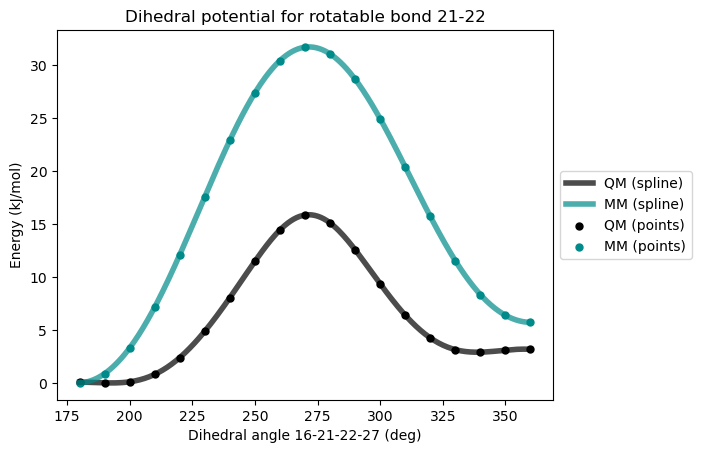

* Info * Fitting the dihedral parameters...                                                                               
* Info * Optimizing dihedral via least squares fitting...                                                                 
* Info * New fitted barriers: [2.22536935 2.22536935 2.22536935 2.22536935]                                               
                                                                                                                          
* Info * Validating the fitted force field...                                                                             
                                                                                                                          
* Info *       Dihedral      MM energy(rel)      QM energy(rel)       diff                                                
* Info *   ---------------------------------------------------------------                                                
* Info *      18

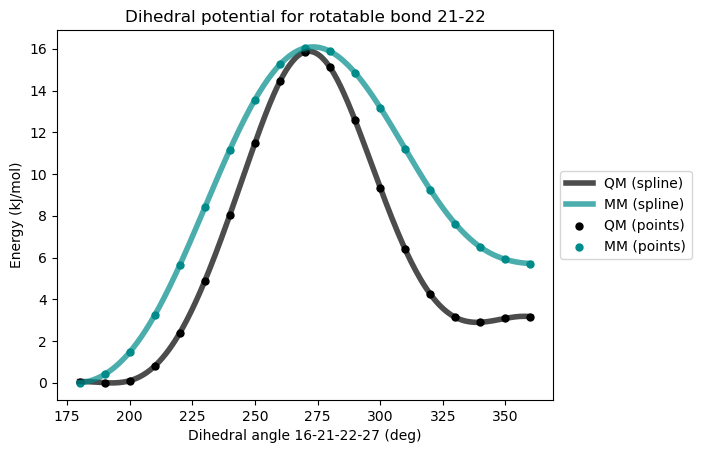

* Info * Dihedral MM parameters have been reparameterized and updated in the topology.                                    


In [6]:
ff_gen.reparameterize_dihedrals(rotatable_bond=(21,22),
                                scan_file="../input_files/16-21-22-27.xyz", 
                                visualize=True)

The rotational barrier is now much improved but the relative energies between the two conformer minima are still not well reproduced, leading to significant errors in the statistical dihedral distributions. As a remedy to this situation, an additional dihedral potential can be added.

In [7]:
ff_gen.add_dihedral((16, 21, 22, 27), 
                    barrier=0.0, 
                    phase=180.0, 
                    periodicity=1)

* Info * Added dihedral 16-21-22-27                                                                                       


We can now restart the reparametrization procedure with this added dihedral angle.

                                          VeloxChem Dihedral Reparameterization                                           
                                                                                                                          
* Info * Rotatable bond selected: 21-22                                                                                   
* Info * Dihedrals involved:[[16, 21, 22, 23], [16, 21, 22, 27], [19, 21, 22, 23], [19, 21, 22, 27]]                      
                                                                                                                          
* Info * Reading QM scan from file...                                                                                     
* Info *   ../input_files/16-21-22-27.xyz                                                                                 
                                                                                                                          
* Info * Perform

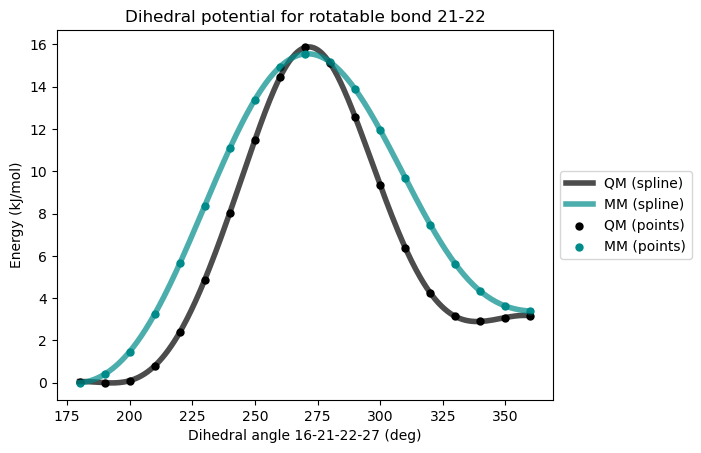

* Info * Dihedral MM parameters have been reparameterized and updated in the topology.                                    


In [9]:
ff_gen.reparameterize_dihedrals(rotatable_bond=(21,22),
                                scan_file="../input_files/16-21-22-27.xyz", 
                                visualize=True,
                                initial_validation=False)

Another dihedral angle can be added for a better agreement with the QM Potential Energy Surface.

In [10]:
ff_gen.add_dihedral((16, 21, 22, 27),
                    barrier=0.0,
                    phase=0.0,
                    periodicity=4)

* Info * Added dihedral 16-21-22-27                                                                                       


And start a new parametrization with this added dihedral angle.

                                          VeloxChem Dihedral Reparameterization                                           
                                                                                                                          
* Info * Rotatable bond selected: 21-22                                                                                   
* Info * Dihedrals involved:[[16, 21, 22, 23], [16, 21, 22, 27], [19, 21, 22, 23], [19, 21, 22, 27]]                      
                                                                                                                          
* Info * Reading QM scan from file...                                                                                     
* Info *   ../input_files/16-21-22-27.xyz                                                                                 
                                                                                                                          
* Info * Perform

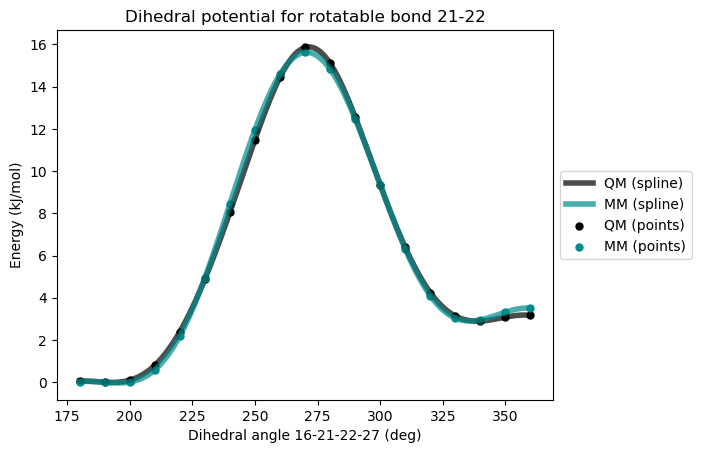

* Info * Dihedral MM parameters have been reparameterized and updated in the topology.                                    


In [11]:
ff_gen.reparameterize_dihedrals(rotatable_bond=(21,22),
                                scan_file="../input_files/16-21-22-27.xyz",
                                visualize=True,
                                initial_validation=False)

| Rotatable Bond | Max difference (kJ/mol) | Std deviation (kJ/mol) |
|----------------|-------------------------|------------------------|
| [21, 22]      | 0.477                   | 0.212                  |

With this excellent agreement between the QM and MM Potential Energy Surface, we can now save the topology as, i. e., Gromacs ouptut files.

In [12]:
ff_gen.write_gromacs_files('HS-276_final', 'MOL')